In [65]:
import torch
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve)


In [66]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)
df.head()

,kmeans_dist,kmeans_cluster,dbscan_cluster,pca_1,pca_2,anomaly_score,nearest_cosine_similarity,dengue
0,0.807903,1.00,0.000000,0.690117,0.530614,1.0,0.248749,1.0
1,0.872944,0.25,0.000378,0.548990,0.361146,1.0,0.372575,0.0
2,0.811521,0.00,0.000755,0.402503,0.733854,1.0,0.528842,0.0
3,0.809303,1.00,0.001133,0.472950,0.346633,0.0,0.441506,0.0
4,0.815355,0.00,0.001511,0.601353,0.324567,1.0,0.329382,1.0


In [67]:
X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [68]:
# TabNetのモデル定義
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TabNetClassifier(n_a=20,n_steps=20,optimizer_params=dict(lr=0.001),device_name=device)

/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [69]:
# モデルの学習
model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['accuracy'],
    max_epochs=1000,
    patience=10,
    batch_size=64,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 1.45662 | val_0_accuracy: 0.664   |  0:00:13s
epoch 1  | loss: 1.06484 | val_0_accuracy: 0.65868 |  0:00:26s
epoch 2  | loss: 0.92758 | val_0_accuracy: 0.66454 |  0:00:39s
epoch 3  | loss: 0.85477 | val_0_accuracy: 0.6246  |  0:00:53s
epoch 4  | loss: 0.8221  | val_0_accuracy: 0.65548 |  0:01:06s
epoch 5  | loss: 0.77832 | val_0_accuracy: 0.66613 |  0:01:20s
epoch 6  | loss: 0.71378 | val_0_accuracy: 0.6672  |  0:01:33s
epoch 7  | loss: 0.69998 | val_0_accuracy: 0.66294 |  0:01:46s
epoch 8  | loss: 0.69662 | val_0_accuracy: 0.64217 |  0:01:59s
epoch 9  | loss: 0.6715  | val_0_accuracy: 0.65176 |  0:02:12s
epoch 10 | loss: 0.65066 | val_0_accuracy: 0.63525 |  0:02:26s
epoch 11 | loss: 0.63179 | val_0_accuracy: 0.63898 |  0:02:39s
epoch 12 | loss: 0.6394  | val_0_accuracy: 0.65335 |  0:02:52s
epoch 13 | loss: 0.63358 | val_0_accuracy: 0.64963 |  0:03:05s
epoch 14 | loss: 0.62735 | val_0_accuracy: 0.66826 |  0:03:18s
epoch 15 | loss: 0.61865 | val_0_accuracy: 0.65122 |  0

/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


最適な閾値: 0.2700, F1スコア: 0.5940
Accuracy: 61.13%
Precision: 0.4560
Recall: 0.8517
F1 Score: 0.5940


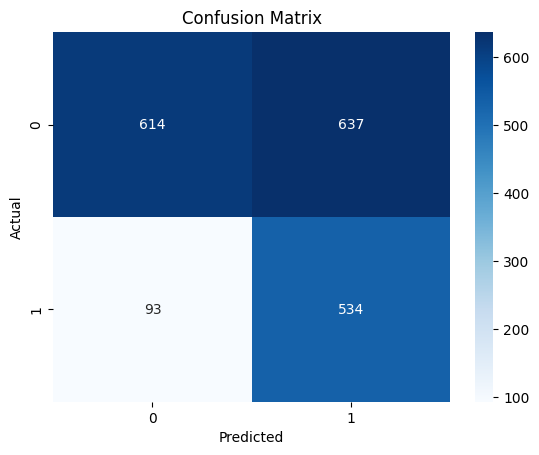

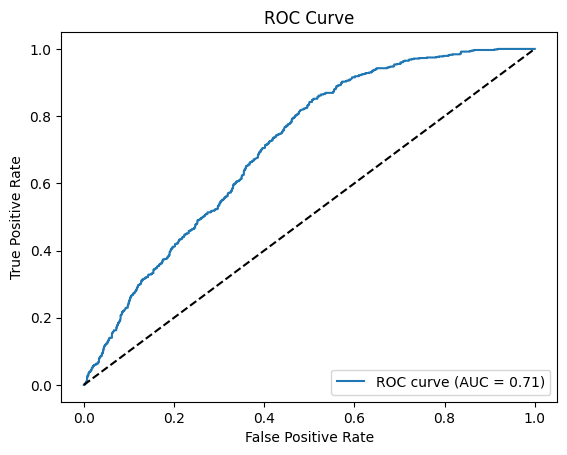

In [70]:
y_prob = model.predict_proba(X_test)[:, 1]  # ポジティブクラスの確率
y_true = y_test  


optimal_threshold = 0.5 
f1_scores = []
thresholds = []


for threshold in np.linspace(0.0, 1.0, num=1001): 
    predictions = (y_prob >= threshold).astype(float)  
    f1 = f1_score(y_true, predictions)
    f1_scores.append(f1)
    thresholds.append(threshold)


max_f1 = max(f1_scores)
optimal_threshold = thresholds[f1_scores.index(max_f1)]
print(f"最適な閾値: {optimal_threshold:.4f}, F1スコア: {max_f1:.4f}")


y_pred = (y_prob >= optimal_threshold).astype(float)

# 精度、適合率、再現率、F1スコア
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 混同行列
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC曲線とAUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 45度線
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
